In [1]:
cd '/Users/quinnunderriner/Desktop/Work/missing_middle/zillow'

/Users/quinnunderriner/Desktop/Work/missing_middle/zillow


In [2]:
import numpy as np
import pandas as pd
import zipfile         
import os
import matplotlib.pyplot as plt
import altair as alt
import DateTime
import re 
import cpi
import warnings
import matplotlib.pyplot as plt
import six
from cols_to_keep import * #small python file i made just with long list of dates we want need, just drops out HMDA data before 2010 and a few other cols, its on github 
import hdma_functions #where all the main functions used in this file are stored
pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

### Load and process HDMA data merge onto counties and AMI bands

In [3]:
#read in 2019 data, filtered for first lien, not primarily for a business or commercial purpose,Home purchase, single family dwelling type, Principal residence and that the loan actually originated 
hmda_ca_19 = hdma_functions.read_in_and_clean_hdma_data("CA_only_2019_public_lar_csv.csv", 2019,"CA")
#read in 2010 data, filtered for single family home, owner occupied, loan for home purchase, loan actually disbursed,1st lien 
hmda_ca_10 = hdma_functions.read_in_and_clean_hdma_data("hmda_2010_ca_originated-records_labels.csv", 2010,"CA")

In [4]:
#read in county level AMI bands, get data for 2010 and 2019 
county_level_AMI_2010, county_level_AMI_2019 = hdma_functions.read_in_ami("year_county_AMI.csv")

In [5]:
# read in MSA level AMI bands 
MSA_level_AMI = pd.read_csv("year_MSA_AMI.csv")

In [6]:
#read in FIPS codes to county mapping 
county_fips = pd.read_csv("county_fips_master.csv", encoding='latin-1') # https://github.com/kjhealy/fips-codes 
county_fips = county_fips[county_fips["state_abbr"]=="CA"]
county_fips = county_fips.rename(columns={"fips":"county_code"})
county_fips = county_fips[["county_name","county_code"]]

In [7]:
#merge county name for 2019 data (2010 data already contains county name )
hmda_ca_19 = hmda_ca_19.merge(county_fips,on="county_code",how="left")
hmda_ca_19 =hmda_ca_19.drop(columns=["county_code"])

In [8]:
#merge on ami data for 2019 data
hmda_ca_19 = hmda_ca_19.merge(county_level_AMI_2019,on="county_name",how="left")
#merge on ami data for 2010 data
hmda_ca_10 = hmda_ca_10.merge(county_level_AMI_2010,on="county_name",how="left")

In [16]:
#create binary variable for if borrower is middle income (80-120AMI or not)
hmda_ca_19['80-120%AMI_HH'] = hdma_functions.middle_income(hmda_ca_19,"applicant_income")
hmda_ca_10['80-120%AMI_HH'] = hdma_functions.middle_income(hmda_ca_10,"applicant_income")

### What Percentage of all loans in a given year are to middle income individuals?

 - Percentage of loans for middle income buyers in california 2019: 23.3% 

In [17]:
hdma_functions.calc_percent_binary_col(hmda_ca_19,"80-120%AMI_HH")

0.23321288274758498

 - Percentage of loans for middle income buyers in california 2010: 26.3% 

In [18]:
hdma_functions.calc_percent_binary_col(hmda_ca_10,"80-120%AMI_HH")

0.2639621073246268

### How has average loan value increased 2010-2019 (inflation adjusted)?

In [19]:
cpi.inflate(hmda_ca_10.loan_amount.mean(),2010)

370942.1912991842

In [20]:
hmda_ca_19.loan_amount.mean()

513674.4751873979

In [21]:
#percent change 
hdma_functions.percent_change(cpi.inflate(hmda_ca_10.loan_amount.mean(),2010),hmda_ca_19.loan_amount.mean())

38.48

There has also been an increase in the average value of these loans: $\$$370,942 (adjusted to 2019 dollars) to $\$$513,674 in 2019 (a CPI adjusted 38 percent increase). 

#### How has average loan value increased 2010-2019 for middle income households

In [22]:
#grab only middle income households 
hmda_ca_19_mid = hmda_ca_19[hmda_ca_19["80-120%AMI_HH"]==1]
hmda_ca_10_mid = hmda_ca_10[hmda_ca_10["80-120%AMI_HH"]==1]

In [23]:
cpi.inflate(hmda_ca_10_mid.loan_amount.mean(),2010)

310949.3773753574

In [24]:
hmda_ca_19_mid.loan_amount.mean()

357950.42321644496

In [25]:
hdma_functions.percent_change(cpi.inflate(hmda_ca_10_mid.loan_amount.mean(),2010),hmda_ca_19_mid.loan_amount.mean())

15.12

There has also been an increase in the average value of these loans: $\$$ 310,949 in 2010 (adjusted here to 2019 dollars) $\$$357,950 in 2019 (a CPI adjusted 15.12% increase). 

#### In absolute numbers, what is the change between the number of middle income households that bought houses by county between 2010 and 2019?

In [26]:
changed_by_location = hdma_functions.change_in_absolute_number(hmda_ca_19_mid, hmda_ca_10_mid)

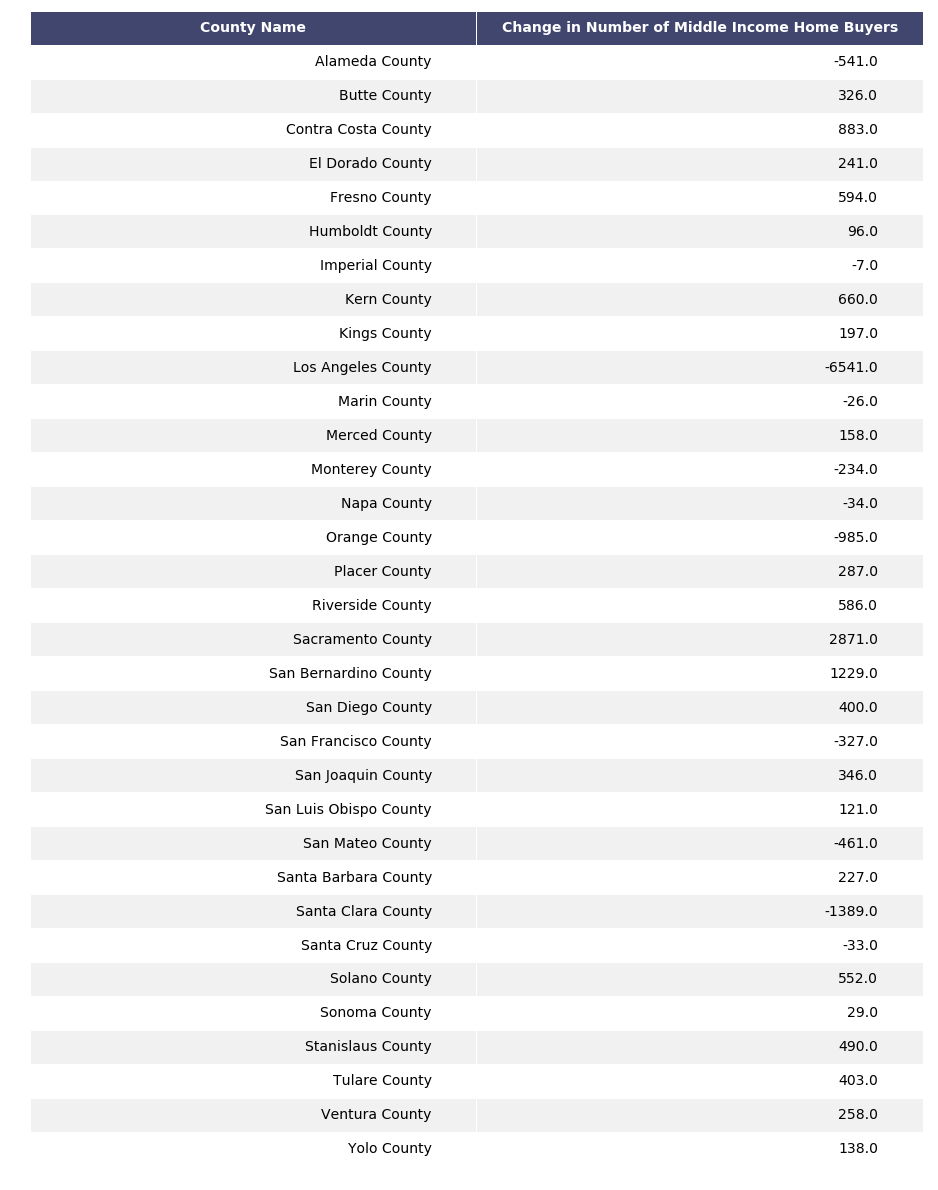

In [27]:
hdma_functions.render_mpl_table(changed_by_location, header_columns=0, col_width=8.0)

#### How much home can a middle income invidividual afford?

Note on how loan affordability is calculated: 

https://www.nar.realtor/research-and-statistics/housing-statistics/housing-affordability-index/methodology

We are assuming 20% down and that 30% of monthly income is the maximum affordable payment. Also assuming a 30 year mortgage.  

See the formula in the above link, which has been used in the calc_home_afford function in hdma_functions.py. Because we are assuming out the 20% down payment, the actual home value is 25% more than what is being calculated below. However, in the HDMA loan data we are seeing value of the loans, not total value of house so we do NOT need to add down payment back in when calculating how many of the loans in the HMDA data would have been 
affordable, but important to note if we want to talk about the cost of loan one can afford VS. value of house one can afford. 

Note: I did some validation checks with the online Zillow mortgage affordability tool https://www.zillow.com/mortgage-calculator/house-affordability/
and the outputs of this function seem reeasonable 

In [57]:
#get max affordable house for each middle income AMI band 
#120% AMI 
affordable_2019_120AMI = hdma_functions.calc_value(hmda_ca_19_mid,"120% AMI", 2019)
affordable_2010_120AMI = hdma_functions.calc_value(hmda_ca_10_mid,"120% AMI", 2010)
affordable_2010_to_2019_120AMI = hdma_functions.merge_years(affordable_2010_120AMI,affordable_2019_120AMI)
#100% AMI 
affordable_2019_100AMI= hdma_functions.calc_value(hmda_ca_19_mid,"100% AMI", 2019)
affordable_2010_100AMI= hdma_functions.calc_value(hmda_ca_10_mid,"100% AMI", 2010)
affordable_2010_to_2019_100AMI = hdma_functions.merge_years(affordable_2010_100AMI,affordable_2019_100AMI)
#80% AMI 
affordable_2019_80AMI= hdma_functions.calc_value(hmda_ca_19_mid,"80% AMI", 2019)
affordable_2010_80AMI=hdma_functions.calc_value(hmda_ca_10_mid,"80% AMI", 2010)
affordable_2010_to_2019_80AMI = hdma_functions.merge_years(affordable_2010_80AMI,affordable_2019_80AMI)